In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import category_encoders as ce
from lightgbm import LGBMClassifier

In [4]:
df = pd.read_csv("machine_learning_engineer_assignment_data.csv")

## Exploratory Analysis

In [5]:
df.dtypes

date             object
numeric0          int64
numeric1        float64
categorical0     object
time             object
target            int64
dtype: object

### Descriptive Statistics

In [6]:
df.describe()

numeric0     numeric1        target
count  10000.000000  5083.000000  10000.000000
mean    4981.998600     4.540035      0.133000
std     2886.313858     2.863159      0.339592
min        0.000000     0.000000      0.000000
25%     2499.750000     2.000000      0.000000
50%     4940.500000     5.000000      0.000000
75%     7487.250000     7.000000      0.000000
max     9999.000000     9.000000      1.000000

In [7]:
df.corr()

numeric0  numeric1    target
numeric0  1.000000  0.010304 -0.189356
numeric1  0.010304  1.000000  0.009822
target   -0.189356  0.009822  1.000000

### Class Bias

In [8]:
df.target.value_counts()

0    8670
1    1330
Name: target, dtype: int64

### Visual Exploration

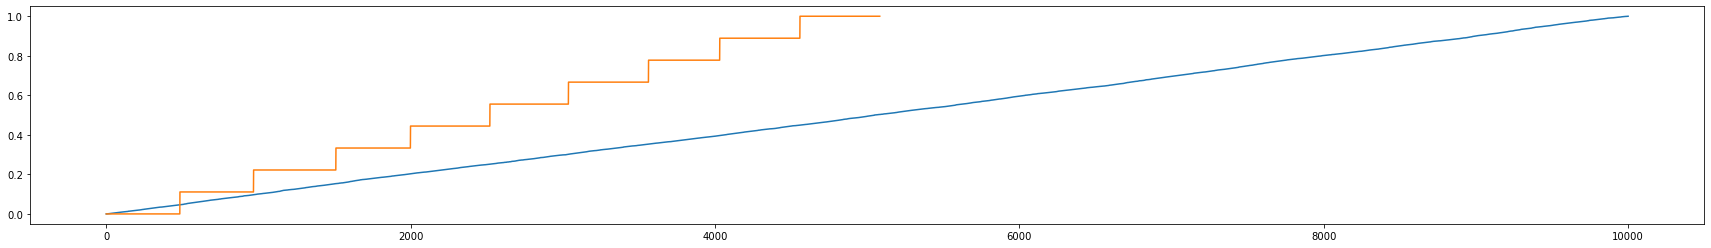

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 4))
plt.plot(df.numeric0.sort_values().reset_index().numeric0 / df.numeric0.max())
plt.plot(df.numeric1.sort_values().reset_index().numeric1 / df.numeric1.max())

## Preprocessing and feature engineering

In [10]:
date_series = pd.to_datetime(df.date)
time_series = pd.to_datetime(df.time)

In [11]:
df = df.assign(year=date_series.dt.year,
               month=date_series.dt.month,
               day=date_series.dt.day,
               n_days=(date_series - date_series.min()) / np.timedelta64(1, 'D'),
               hour=time_series.dt.hour,
               minute=time_series.dt.minute,
               second=time_series.dt.second,
               n_seconds=(time_series - time_series.min()) / np.timedelta64(1, 's'))

In [12]:
X, y = df.drop(['target', 'date', 'time'], axis=1), df['target']
X.shape, y.shape

((10000, 11), (10000,))

## Model selection

In [13]:
df = df.sample(n=len(df))  # Some things expect unsorted entries, notably CatBoostEncoder, which is commented out :)
categorical_features = ['categorical0', 'year', 'month', 'day', 'hour', 'minute', 'second']
numeric_features = ['numeric0', 'numeric1', 'n_days', 'n_seconds']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

encoder_list = [
    ce.backward_difference.BackwardDifferenceEncoder, 
    ce.basen.BaseNEncoder,
    ce.binary.BinaryEncoder,
    # ce.cat_boost.CatBoostEncoder,
    ce.hashing.HashingEncoder,
    ce.helmert.HelmertEncoder,
    ce.james_stein.JamesSteinEncoder,
    ce.one_hot.OneHotEncoder,
    # ce.leave_one_out.LeaveOneOutEncoder,
    ce.m_estimate.MEstimateEncoder,
    ce.ordinal.OrdinalEncoder,
    ce.polynomial.PolynomialEncoder,
    ce.sum_coding.SumEncoder,
    ce.target_encoder.TargetEncoder,
    ce.woe.WOEEncoder,
]

scores = []
for encoder in encoder_list:
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # FIXME use more informed selection criteria than copy paste
        ('scaler', preprocessing.StandardScaler()),
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('woe', encoder()),
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ])
    
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=500)),
    ])
    
    model = pipe.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    scores.append((encoder, f1_score(y_test, y_pred, average='macro')))

In [14]:
sorted_scores = sorted(scores, key=lambda x: x[1])
best = sorted_scores[-1]
print(best)
best_encoder, best_score = best

(<class 'category_encoders.target_encoder.TargetEncoder'>, 0.652844744455159)


In [15]:
classifier_list = [
    LogisticRegression(),
    RandomForestClassifier(n_estimators=500),
    LGBMClassifier(),
    DummyClassifier(strategy='most_frequent'),
]

scores = []
for classifier in classifier_list:
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', preprocessing.StandardScaler()),
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('woe', best_encoder()),
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ])
    
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier),
    ])
    
    model = pipe.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    scores.append((classifier, f1_score(y_test, y_pred, average='macro')))

In [16]:
sorted_scores = sorted(scores, key=lambda x: x[1])
best = sorted_scores[-1]
print(best)
best_classifier, best_score = best

(LGBMClassifier(), 0.6568522957101338)


In [22]:
from joblib import dump
dump(preprocessor, "preprocessor.joblib"), dump(best_classifier, "classifier.joblib")

(['preprocessor.joblib'], ['classifier.joblib'])

In [20]:
import json
open("stats.json", "w").write(json.dumps({"classifier": repr(best_classifier), "f1_score": best_score}))

66